<a href="https://colab.research.google.com/github/omartinez182/data-science-notebooks/blob/master/Nested_Cross_Validation_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nested Cross-Validation in Python

This notebook will illustrate the implementation of Nested Cross-Validation in Python using Sklearn.

In [1]:
#Load libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

Let’s start by loading the wine dataset from sklearn.datasets.


In [2]:
#Load data
X, y = load_wine(return_X_y=True)
X.shape, y.shape

((178, 13), (178,))

Now, we proceed to instantiate the classifier and then specify the number of rounds/trials we would like to run, in other words, how many times we’ll perform the whole process of going through both the inner and outer loops. Because this is computationally expensive and we are doing this only for demonstration purposes, let's choose 20. Remember, the number of rounds represents how many times you’ll split your dataset differently on each of the CV processes.


In [5]:
#Set a seed to ensure reproducibility
seed = 42 

#Instantiate the Random Forest classifier
rf = RandomForestClassifier(random_state=seed)

#Number of rounds
rounds = 20

The next step involves creating a dictionary that will establish the hyperparameter space that we are going to explore in each round, and we also create two empty arrays to store the results from the nested and the non-nested processes.



In [4]:
#Define the hyperparameter grid
rf_param_grid = {'max_depth': [10, 50],
                 'n_estimators': [100, 200, 400]}

#Create arrays to store the scores
outer_scores = np.zeros(rounds)
nested_scores = np.zeros(rounds)

The next step is crucial, we are going to create a for loop that will iterate for the number of rounds we've specified, and that will contain two different cross-validation objects.

For this example, we'll use 5-fold cross-validation for both the outer and inner loops, and we use the value of each round (i) as the random_state for both CV objects.

Then, we proceed to create and configure the object to perform the hyperparameter optimization, in this case, we'll use grid-search. Notice that we pass to the grid-search the 'inner_cv' object as the cross-validation method.

Subsequently, notice that for the final scores of the "Nested" cross-validation process, we use the cross_val_score function and feed it the classifier object 'clf' (includes its own CV process) which is the object we used to perform the hyperparameter optimization, and also the 'outer_cv' cross-validation object. In this process, we also fit the data and then store the results of each process inside the empty arrays we created before.


In [ ]:
# Loop for each round
for i in range(rounds):

    #Define both cross-validation objects (inner & outer)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

    # Non-nested parameter search and scoring
    clf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=inner_cv)
    clf.fit(X, y)
    outer_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

We can now take the difference in the accuracy of both the "simple" cross-validation and the nested cross-validation processes to see how much they disagree with each other on average.

In this case, by nested cross-validation scores we mean the scores of the nested process (not to be confused with the inner cross-validation process), and we compare them with the scores of the regular process (non-nested).



In [ ]:
#Take the difference from the non-nested and nested scores
score_difference = outer_scores - nested_scores

print("Avg. difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

Avg. difference of 0.001698 with std. dev. of 0.003162.


As we can see, the non-nested scores on average are more optimistic, thus, relying solely on the information of that process might result in a biased model selection. 

We can also plot the scores of each iteration and create a plot to get a visual comparison of how both processes behaved.


Text(0.5, 1.1, 'Non-Nested vs Nested Cross-Validation on the Wine Dataset')

<Figure size 576x396 with 0 Axes>

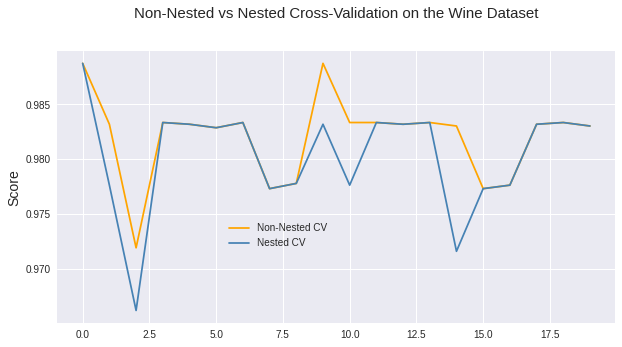

In [ ]:
# Plot scores on each trial for nested and non-nested cross-validation
plt.style.use('seaborn')
plt.tight_layout()
plt.figure(figsize=(10,5))
outer_scores_line, = plt.plot(outer_scores, color='orange')
nested_line, = plt.plot(nested_scores, color='steelblue')
plt.ylabel("Score", fontsize="14")
plt.legend([outer_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested vs Nested Cross-Validation on the Wine Dataset",
          x=.5, y=1.1, fontsize="15")
# Save the plot
plt.savefig("nested-vs-non-nested.png", dpi=150)

Finally, we can also plot the difference in each round for both CV processes.

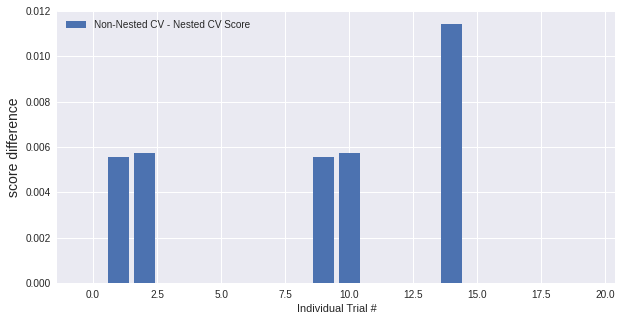

In [ ]:
# Plot bar chart of the difference.
plt.figure(figsize=(10,5))
plt.tight_layout()
difference_plot = plt.bar(range(rounds), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

#Save the plot
plt.savefig("diff-nested-vs-non-nested.png", dpi=150)

While cross-validation is an industry-standard to assess generalization, it’s important to consider the problem at hand and to potentially implement a more rigorous process to avoid selection bias while choosing the final model. From personal experience, this is significatively more important when you’re dealing with small datasets and when the system it’s meant to support non-trivial decisions. 

Nested-cross validation is not a perfect process, it is computationally expensive, and it’s definitely not a panacea for poor model performance in production, however, in most scenarios the process will allow you to get a more realistic view of the generalization capacity of each model.